In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [53]:
# set theme
plt.style.use('seaborn')
sns.set_style('darkgrid')

<ipython-input-53-c7bd5f3812ab>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [54]:
prices = pd.read_csv('finaldata.csv', parse_dates=['Timestamp'], index_col='Timestamp')

prices = prices.apply(lambda col: col.abs() if col.name != 'Timestamp' else col)


prices = prices.dropna(axis=1)
returns = np.log(prices).diff().dropna()

In [55]:
form_start = '2017-11-20'
form_end = '2020-05-19'
trade_start = '2021-05-20'
trade_end = '2022-11-19'

prices_form = prices[form_start:form_end]
prices_trade = prices[trade_start:trade_end]
returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]


In [56]:

# Calculate Kendall's tau for each pair of stocks
results = pd.DataFrame(columns=['tau'])

for s1 in returns_form.columns:
    for s2 in returns_form.columns:
        if (s1!=s2) and (f'{s2}-{s1}' not in results.index):
            results.loc[f'{s1}-{s2}'] = stats.kendalltau(returns_form[s1], returns_form[s2])[0]

In [57]:
results.to_csv('pairs_tau.csv')
results = pd.read_csv('pairs_tau.csv', index_col=0)
results.sort_values(by='tau')

,tau
Instr1-Instr17,0.483457
Instr1-Instr16,0.500545
Instr2-Instr17,0.540825
Instr1-Instr13,0.555998
Instr2-Instr16,0.558861
...,...
Instr12-Instr13,0.969471
Instr9-Instr10,0.969480
Instr16-Instr17,0.970946
Instr11-Instr12,0.971729


In [58]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

In [59]:
from statsmodels.tsa.stattools import coint

selected_stocks = []
selected_pairs = []
num_pairs = 25 # number of pairs to select

for pair in results.sort_values(by='tau', ascending=False).index:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        coint_pval = coint(prices_form[s1], prices_form[s2])[1] # ADF-test p-value
        if coint_pval<0.1:
            selected_stocks.append(s1)
            selected_stocks.append(s2)
            selected_pairs.append(pair)

    if len(selected_pairs) == num_pairs:
        break

In [60]:
print(selected_pairs)

['Instr10-Instr11', 'Instr16-Instr17', 'Instr12-Instr13', 'Instr8-Instr9', 'Instr4-Instr5', 'Instr2-Instr3', 'Instr6-Instr7']


In [61]:
results.loc[selected_pairs]


,tau
Instr10-Instr11,0.973646
Instr16-Instr17,0.970946
Instr12-Instr13,0.969471
Instr8-Instr9,0.969111
Instr4-Instr5,0.950807
Instr2-Instr3,0.937778
Instr6-Instr7,0.932423


<Axes: xlabel='Timestamp'>

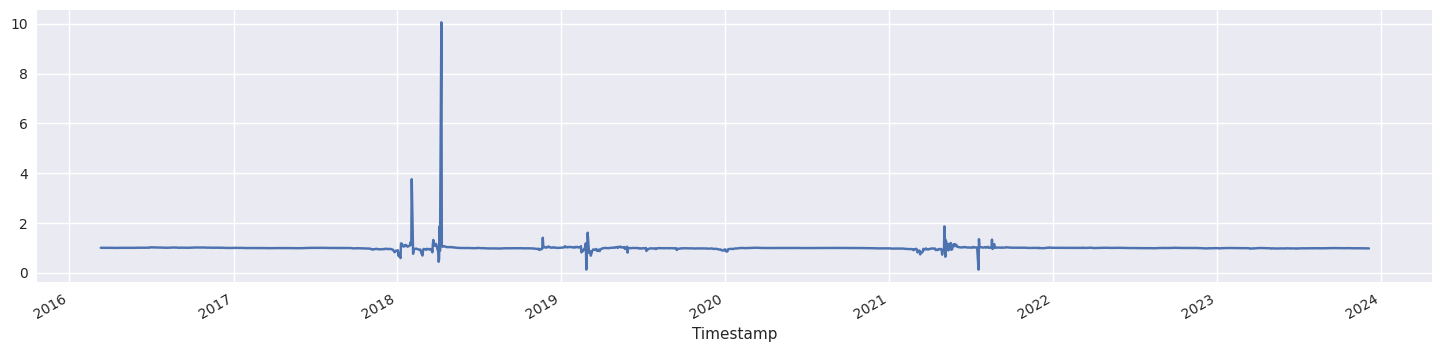

In [75]:
pair = 'Instr10-Instr11'
s1,s2 = parse_pair(pair)
spread = prices[s1]/prices[s2]

spread.plot(figsize=(18,4))

In [93]:
import statsmodels.api as sm

mod = sm.tsa.MarkovRegression(spread, k_regimes=2, switching_variance=True)
res = mod.fit(search_reps=200)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [94]:
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  391
Model:               MarkovRegression   Log Likelihood                1186.442
Date:                Thu, 21 Dec 2023   AIC                          -2360.884
Time:                        09:38:58   BIC                          -2337.072
Sample:                             0   HQIC                         -2351.446
                                - 391                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0281      0.013     79.173      0.000       1.003       1.054
sigma2         0.0136      0.002      6.027      0.000       0.009       0.018
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0036      0.000   2578.794      0.000       1.003       1.004
sigma2      3.704e-05   3.58e-06     10.337      0.000       3e-05    4.41e-05
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9822      0.016     62.245      0.000       0.951       1.013
p[1->0]        0.0062      0.005      1.332      0.183      -0.003       0.015
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [96]:
res.expected_durations


array([ 56.19762753, 161.7955794 ])

In [97]:
res.params['const[0]']


1.028094327940598

In [98]:
res.params


p[0->0]      0.982206
p[1->0]      0.006181
const[0]     1.028094
const[1]     1.003635
sigma2[0]    0.013633
sigma2[1]    0.000037
dtype: float64

Text(0.5, 1.0, 'Probability of high-mean regime')

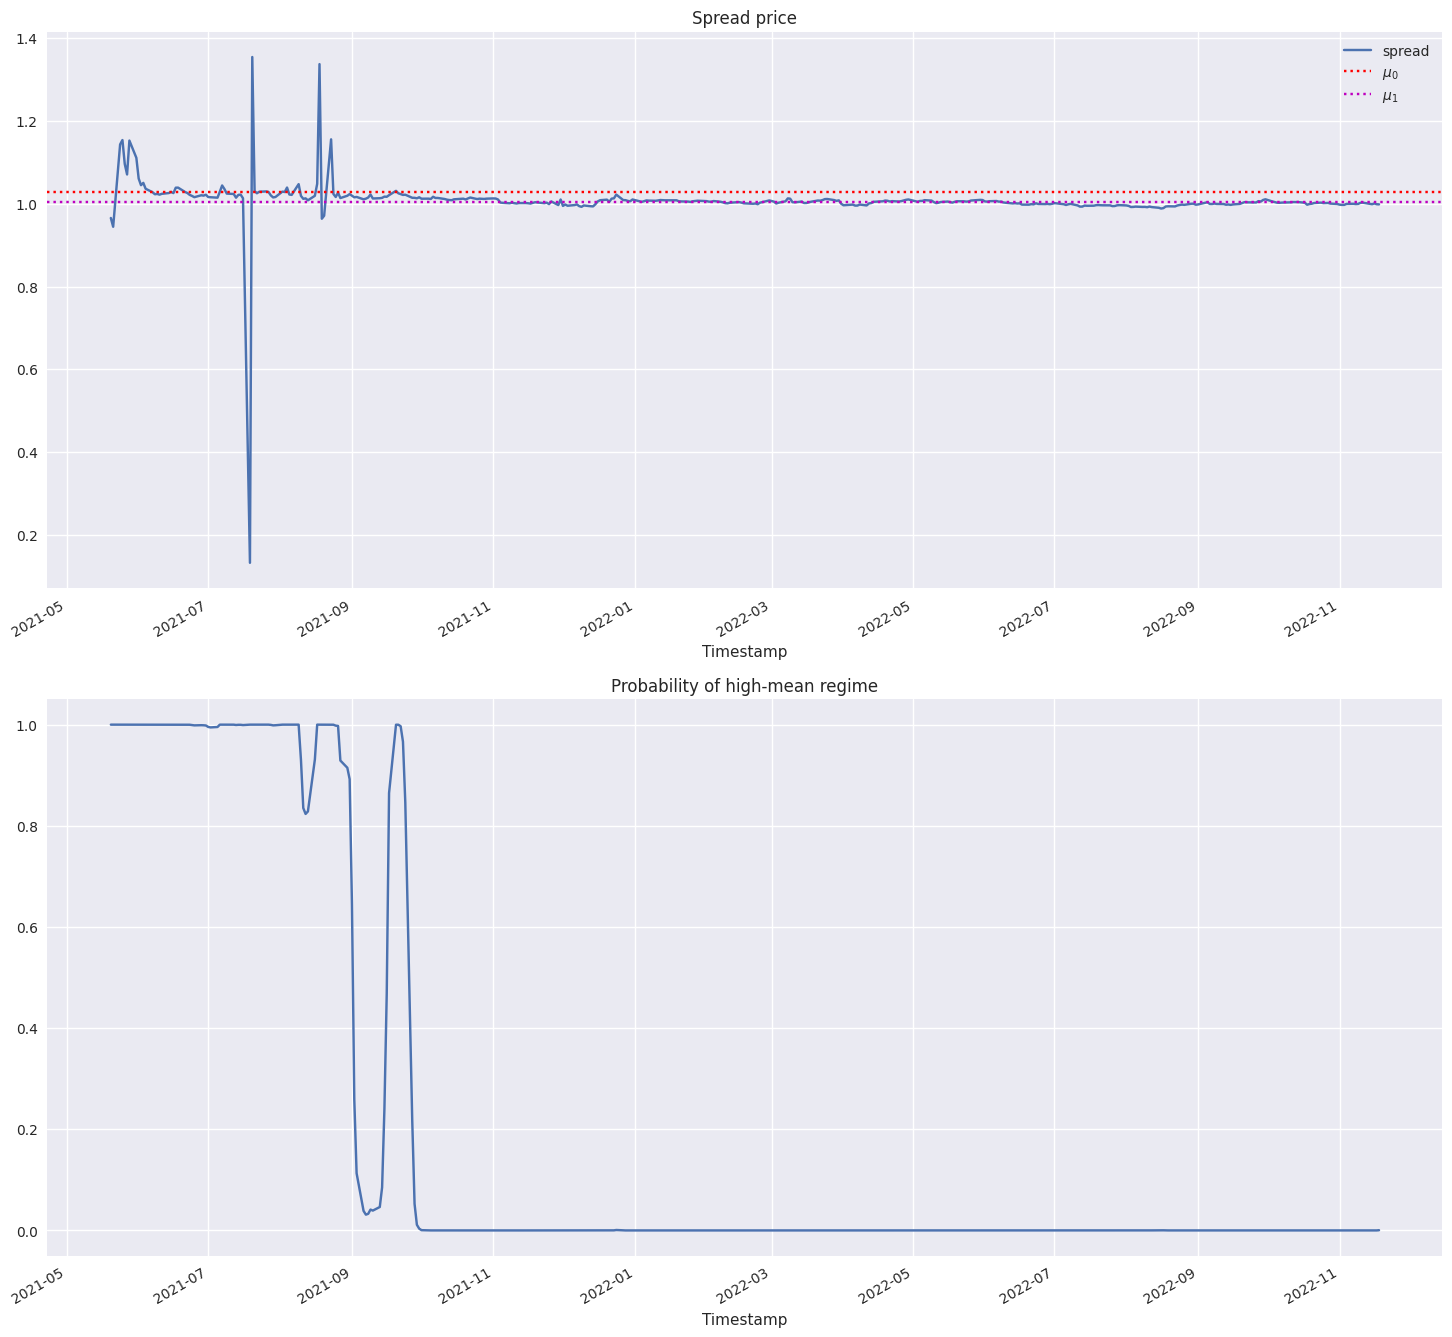

In [100]:
fig, axs = plt.subplots(2,1,figsize=(18,18))
spread.plot(ax=axs[0], label='spread')
axs[0].axhline(y=res.params['const[0]'], label=r'$\mu_0$', linestyle='dotted', c='r')
axs[0].axhline(y=res.params['const[1]'], label=r'$\mu_1$', linestyle='dotted', c='m')
axs[0].set_title('Spread price')
axs[0].legend()
res.smoothed_marginal_probabilities[0].plot(ax=axs[1])
axs[1].set_title('Probability of high-mean regime')


In [ ]:

# %%capture --no-display

# markov_params = {}

# for pair in selected_pairs:
#     s1,s2 = parse_pair(pair)

#     markov_df = pd.DataFrame(index=prices_trade.index, columns=['prob_high', 'mu_high', 'sigma_high',
#                                                                 'prob_low', 'mu_low', 'sigma_low'])

#     for t in prices_trade.index:
#         prices_tmp = prices.loc[:t]
#         prices_tmp = prices_tmp.iloc[-250:] # 250 days trailing window
#         spread = prices_tmp[s1] / prices_tmp[s2]

#         # repeat until convergence
#         converged = False
#         while converged==False:
#             mod = sm.tsa.MarkovRegression(spread, k_regimes=2, switching_variance=True)
#             res = mod.fit(search_reps=100)
#             if res.smoothed_marginal_probabilities[0][-1] > 0: # check if converged
#                 converged=True

#         # determine index of high and low regimes
#         if res.params['const[0]'] > res.params['const[1]']:
#             high_reg = 0
#             low_reg = 1
#         else:
#             high_reg = 1
#             low_reg = 0

#         # save regime parameters
#         mu_high = res.params[f'const[{high_reg}]']
#         sigma_high = np.sqrt(res.params[f'sigma2[{high_reg}]'])
#         mu_low = res.params[f'const[{low_reg}]']
#         sigma_low = np.sqrt(res.params[f'sigma2[{low_reg}]'])

#         prob_high = res.smoothed_marginal_probabilities[high_reg][-1]
#         prob_low = res.smoothed_marginal_probabilities[low_reg][-1]

#         markov_df.loc[t] = [prob_high, mu_high, sigma_high, prob_low, mu_low, sigma_low]

#     markov_params[pair] = markov_df


In [101]:
import pickle
pickle.dump(markov_params, open('markov_params.p', 'wb'))
markov_params = pickle.load(open('markov_params.p', 'rb'))


In [102]:
delta = 1.645
rho = 0.7

algo_returns = pd.DataFrame(index=prices_trade.index, columns=selected_pairs)

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    spread = prices_trade[s1] / prices_trade[s2]

    # calculate positions
    positions = pd.DataFrame(index=prices_trade.index, columns=[s1,s2])
    markov_df = markov_params[pair]
    condition_short_high = (spread > markov_df['mu_high'] + delta * markov_df['sigma_high'])
    positions[condition_short_high] = [-1,1]

    condition_long_high = ((spread < markov_df['mu_high'] - delta * markov_df['sigma_high']) &
                           (markov_df['prob_high'] > rho))
    positions[condition_long_high] = [1,-1]

    condition_short_low = ((spread > markov_df['mu_low'] + delta * markov_df['sigma_low']) &
                           (markov_df['prob_low'] > rho))
    positions[condition_short_low] = [-1,1]

    condition_long_low = (spread < markov_df['mu_low'] - delta * markov_df['sigma_low'])
    positions[condition_long_low] = [1,-1]

    positions = positions.fillna(0)

    # calculate returns
    simple_ret = (np.exp(returns_trade[[s1,s2]])-1) # transform log-returns to simple returns
    ret = (positions.shift() * simple_ret).sum(axis=1) * 2 # double capital (from short positions)
    algo_returns[pair] = ret

KeyError: ignored

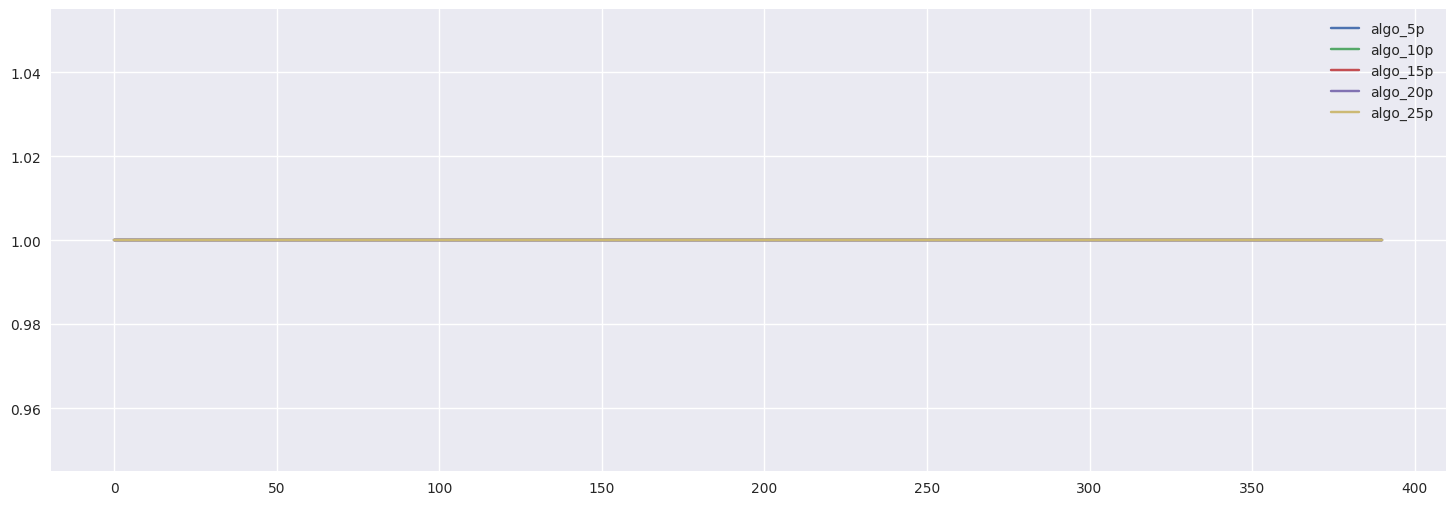

In [103]:
algo_cumret = {}

for num_pairs in [5,10,15,20,25]:
    algo_cumret[f'{num_pairs}p'] = np.nancumprod(algo_returns[selected_pairs[:num_pairs]].sum(axis=1)
                                                 / num_pairs + 1)

plt.figure(figsize=(18,6))
for k in algo_cumret.keys():
    plt.plot(algo_cumret[k], label=f'algo_{k}')
plt.legend()

In [104]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)

    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)

    return total_return, apr, sharpe, maxDD, maxDDD

In [105]:
metrics = pd.DataFrame(index=algo_cumret.keys(), columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])
for k in algo_cumret.keys():
    metrics.loc[k] = calculate_metrics(algo_cumret[k])
metrics.loc['Instr'] = calculate_metrics(vbr_cumret)
metrics

<ipython-input-104-8ed914f6bee2>:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)


,Total return,APR,Sharpe,MaxDD,MaxDDD
5p,0.0,0.0,NaN,0.0,0.0
10p,0.0,0.0,NaN,0.0,0.0
15p,0.0,0.0,NaN,0.0,0.0
20p,0.0,0.0,NaN,0.0,0.0
25p,0.0,0.0,NaN,0.0,0.0
Instr,-0.017632,-0.011759,0.06177,-0.212174,260.0
